In [16]:
#필요한 패키지 불러오기

import pandas as pd
import numpy as np
import warnings
import re
import nltk
import itertools

warnings.filterwarnings('ignore')

In [17]:
#크롤링 파일 불러오기

posts = pd.read_csv('post.csv')
comments = pd.read_csv('comment.csv')

print('Post shape: ', posts.shape)
print('Comments shape: ', comments.shape)

Post shape:  (88262, 9)
Comments shape:  (399029, 50)


In [18]:
posts

,Unnamed: 0,title,score,id,url,num_comments,created_utc,selftext,link_flair_text
0,0,Why are Korean adjumas chewing gum all the time?,5,9k2vxt,https://www.reddit.com/r/korea/comments/9k2vxt...,30,1538276294,I would guess about 75% of adjumas I see on pu...,NaN
1,1,First time traveling to Korea,0,9k2nmj,https://i.redd.it/dmht81rucap11.jpg,2,1538274012,NaN,NaN
2,2,Korean height,0,9k2n2j,https://www.reddit.com/r/korea/comments/9k2n2j...,23,1538273861,"Hey guys, Chinese male from Australia.\n\nIm c...",NaN
3,3,Modern Korean history book recommendations?,64,9k0cep,https://www.reddit.com/r/korea/comments/9k0cep...,27,1538253626,I'm looking for books that cover modern Korean...,NaN
4,4,Female Police Officer Physical Ability Test In...,0,9jzyz0,https://www.youtube.com/watch?v=MHyBaKMErMY,23,1538250658,NaN,NaN
...,...,...,...,...,...,...,...,...,...
88257,88257,Apps that scan for Japanese products,0,ejo11l,https://www.reddit.com/r/korea/comments/ejo11l...,12,1578095359,[removed],사회 | Society
88258,88258,Trump's assassination of Iranian general Solei...,332,ejn0zn,https://twitter.com/henriferon/status/12131678...,281,1578090991,NaN,정치 | Politics
88259,88259,Confessions Of A Former K-pop Idol (ft. Crayon...,1,ejmta6,https://www.youtube.com/watch?v=KdOA5BCwBi0,0,1578090060,NaN,문화 | Culture
88260,88260,Korean TV-shows and other forms of pop-culture?,2,ejmnnn,https://www.reddit.com/r/korea/comments/ejmnnn...,43,1578089382,Hi. For a pretty long time I've been a big fan...,레저 | Leisure


In [19]:
#포스트 데이터 전처리

#1.flair 공백 제거
posts.isnull().sum()
posts = posts[(posts.link_flair_text.notnull())]
posts.reset_index(drop=True,inplace=True)

#2. flair 한글만 남기고 제거
posts['link_flair_text']=posts['link_flair_text'].str.replace(pat=r'[^ㄱ-ㅣ가-힣]+', repl= r'', regex=True)
posts['link_flair_text']= posts['link_flair_text'].str.replace(pat=r'[^\w]', repl=r'', regex=True)
posts['link_flair_text'].str.strip()
posts['link_flair_text']

#3. flair 리스트 정리
flair_list = ["문화",
                "생활",
                "경제",
                "정치",
                "자연",
                "역사",
                "레저와 취미", "레저", "취미",
                "이민",
                "건강",
                "시장",
                "개인",
                "유머",
                "범죄",
                "부고"]

#4. posts 전처리 코드
posts = posts[posts['link_flair_text'].isin(flair_list)]
posts['title'] = posts['title'].apply(lambda x: re.sub('[^A-Za-z]', ' ', x))
posts = posts[~posts['selftext'].isin(['[removed]', '[deleted]'])]
posts['selftext'] = posts['selftext'].replace(np.nan, '')
posts = posts[posts['num_comments'] >= 4]
posts.rename(columns={'link_flair_text': 'flair'}, inplace=True)
posts['flair'] = posts['flair'].apply(lambda x: "레저와 취미" if x=="레저" else x)
posts['flair'] = posts['flair'].apply(lambda x: "레저와 취미" if x=="취미" else x)

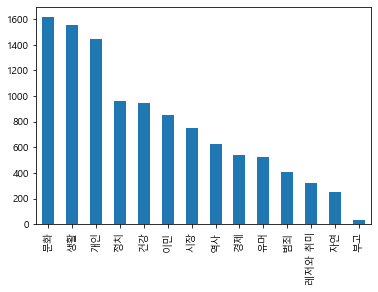

In [21]:
# 5. post flair 분포 확인
import matplotlib.pyplot as plt 
import seaborn as sns 

%matplotlib inline
plt.rcParams['font.family'] = 'Malgun Gothic'

posts['flair'].value_counts().plot(kind='bar')

In [22]:
# 6. post reset index
posts.reset_index(drop=True,inplace=True)

In [23]:
# 7. post 타이틀+본문
for i in range(len(posts)) : 
     if posts['selftext'].isnull()[i] == False : 
        posts.loc[i,'title'] = str(posts.iloc[i]['title']) + str(posts.iloc[i]['selftext'])
posts.drop('selftext',inplace=True, axis=1)

In [24]:
#코멘트 데이터 전처리

# 1. 필요한 칼럼만 추출
comments = comments.loc[:, ['link_id', 'body', 'score', 'created_utc']]

# 2. [deleted], [removed] 등 제거
comments = comments[~comments['body'].isin(['[deleted]', '[removed]',"Thanks for posting your photograph on", "Your submission", "your submission"])]

# 3. link_id 앞 3자리 제거
comments['link_id'] = comments['link_id'].apply(lambda x: x[3:])

# 4. body에서 영문자, 숫자 빼고 제거
comments['body'] = comments['body'].str.replace('[^A-Za-z1-9]+', ' ')

# 5. body에서 null값 제거
comments = comments.dropna(subset=['body'])

In [25]:
#포스트 별 코멘트 말뭉치 만들기

# 1.딕셔너리 생성
dict = {}

for link_id, body in comments[['link_id', 'body']].values:
    if link_id in dict:
        dict[link_id].append(body)
    else:
        dict[link_id] = [body]
        
# 2. 말뭉치 생성
comments_corpus = pd.DataFrame(dict.items())
comments_corpus.columns = ['id', 'comments']
comments_corpus

# 3. 컴바인드 데이터 프레임 생성
combined = pd.merge(posts, comments_corpus, on='id', how='left')
combined = combined.dropna(subset=['comments'])
combined.reset_index(drop=True,inplace=True)
combined.head()

,Unnamed: 0,title,score,id,url,num_comments,created_utc,flair,comments
0,12,Buying a suitcase in Seoul Hello there! Here‘s...,1,9jx3zh,https://www.reddit.com/r/korea/comments/9jx3zh...,13,1538230515,시장,[Haven t been over there for awhile but there ...
1,18,Korea introduces new point system for job seek...,36,9jw36t,https://www.youtube.com/watch?v=IrZHXBn8zLE,28,1538222833,이민,[This is only makes getting a job seeking visa...
2,36,How to work legally in Korea on American citiz...,3,9jsxq6,https://www.reddit.com/r/korea/comments/9jsxq6...,22,1538186675,이민,"[yeah hope ur conversational korean is good , ..."
3,67,Is it possible to find a good American male in...,0,9jkrei,https://www.reddit.com/r/korea/comments/9jkrei...,9,1538117983,생활,[If you don t trust men looking for women why ...
4,75,An American seeking some help buying a Korean ...,0,9jirv7,https://www.reddit.com/r/korea/comments/9jirv7...,4,1538098636,시장,[https www harum io products adidas ultra boos...


In [27]:
# 컴바인드 파일 전처리

#1. 불용어 사전 불러오기
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
english_stop_list = list(stopwords.words('english'))
print(english_stop_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [28]:
#2.리플레이스 함수 생성

import re
replacement_patterns = [ (r'won\'t', 'will not'), (r'can\'t', 'cannot'), (r'i\'m', 'i am'), (r'ain\'t', 'is not'), (r'(\w+)\'ll', '\g<1> will'), (r'(\w+)n\'t', '\g<1> not'), (r'(\w+)\'ve', '\g<1> have'), (r'(\w+)\'s', '\g<1> is'), (r'(\w+)\'re', '\g<1> are'), (r'(\w+)\'d', '\g<1> would'), ] 


class RegexpReplacer(object):
    def __init__(self, patterns=replacement_patterns):
        self.patterns = [(re.compile(regex), repl) for (regex, repl) in patterns]

    def replace(self, text):
        s = text
        for (pattern, repl) in self.patterns:
            s = re.sub(pattern, repl, s)
        return s
    
replacer = RegexpReplacer()

In [31]:
#3. 토큰화 함수 만들기

from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
lemmatizer = WordNetLemmatizer()


def title_tokenize(post_title):

    post_text = post_title
    post_text = re.sub("[^a-zA-Z]"," ", post_text)
    post_text=post_text.lower()
    post_text=replacer.replace(post_text)
    sentence_list = sent_tokenize(post_text)
    token_sentence_list = []
    
    for sentence in sentence_list:
        word_list = word_tokenize(sentence)
        token_sentence_list.append(word_list)
        
    for token_sentence in token_sentence_list:
        for token in token_sentence:
            if token in english_stop_list:
                token_sentence.remove(token)
                
    tag_sentence_list = []
    
    for token_sentence in token_sentence_list:
        tag_list = nltk.tag.pos_tag(token_sentence)
        tag_sentence_list.append(tag_list)
        
    #stem_sentence_list = []
    
    #for tag_sentence in tag_sentence_list:
    #    print([rs.stem(word) for word, pos in tag_sentence])
    #    stem_list = [rs.stem(word) for word, pos in tag_sentence]
    #    stem_sentence_list.append(stem_list)
    
    #stem_tag_sentence_list = []
    
    #for stem_sentence in stem_sentence_list:
    #    stem_tag_list = nltk.tag.pos_tag(stem_sentence)
    #    stem_tag_sentence_list.append(stem_tag_list)
    
    for tag_sentence in tag_sentence_list:
        
        lemma_sentence = []
        
        for word, pos in tag_sentence:
            if pos in ["VB", "VBD", "VBG", "VBN", "VBP"]:
                pos='v'
                lemma_sentence.append(lemmatizer.lemmatize(word, pos=pos))
            elif pos in ["NN", "NNS", "NNP", "NNPS"]:
                pos='n'
                lemma_sentence.append(lemmatizer.lemmatize(word, pos=pos))
            elif pos in ["JJ", "JJR", "JJS"]:
                pos='a'
                lemma_sentence.append(lemmatizer.lemmatize(word, pos=pos))
            else:
                lemma_sentence.append(lemmatizer.lemmatize(word))
                
        #print("Lemma 후: ", lemma_sentence)
        return lemma_sentence

# title열 토큰화
combined['title_tokenized'] = combined['title'].apply(title_tokenize)
combined = combined[(combined.title_tokenized.notnull())]
combined.reset_index(drop=True,inplace=True)

In [32]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10761 entries, 0 to 10760
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       10761 non-null  int64 
 1   title            10761 non-null  object
 2   score            10761 non-null  int64 
 3   id               10761 non-null  object
 4   url              10761 non-null  object
 5   num_comments     10761 non-null  int64 
 6   created_utc      10761 non-null  int64 
 7   flair            10761 non-null  object
 8   comments         10761 non-null  object
 9   title_tokenized  10761 non-null  object
dtypes: int64(4), object(6)
memory usage: 840.8+ KB


In [ ]:
combined.to_csv('combined.csv')